In [77]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

# Black-Scholes选择期权 St取某一个值的时候
def black_scholes_call(S, K, r, sigma, T):
    return (S * norm.cdf(d1(S, K, r, sigma, T)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T)))

def black_scholes_put(S, K, r, sigma, T):
    return (K * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T)) - S * norm.cdf(d1(S, K, r, sigma, T)))

def d1(S, K, r, sigma, T):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma * np.sqrt(T)

# 选择期权的定价逻辑
def chooser_option(S, K, r, sigma, U, T):
    call_value = black_scholes_call(S, K, r, sigma, T - U)
    put_value = black_scholes_put(S, K, r, sigma, T - U)
    Xu = max(call_value, put_value)
    return  Xu

S0 = 10      # 初始价格
K = 10       # 执行价格
r = 0.1      # 无风险利率
sigma = 0.1   # 股票波动率
U = 4       # 选择时间（年）
T = 8         # 到期时间（年）
Xu = 0        # t时间的期权价格
M = 10000    # 模拟次数
N = 2       # 时间步数

# 蒙特卡洛模拟选择期权价值 （BS的最终答案）
def monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M):
    option_values = np.zeros(M)
    
    # dt = T / N
    
    for i in range(M):
        #stock_path = np.zeros(N + 1)
        #stock_path[0] = S0
        #for t in range(1, N + 1):
        #    stock_path[t] = stock_path[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal())
        
         #St_U = stock_path[int(U / dt)]
        
        SU = S0* np.exp((r - 0.5 * sigma ** 2) * U + sigma * np.sqrt(U) * np.random.normal())
        
        option_values[i] = chooser_option(SU, K, r, sigma, U, T)
    
    return (np.mean(option_values))* np.exp(-r * U)

chooser_option_price = monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M)

print(f"The estimated chooser option price at S0 is: {chooser_option_price:.2f}")

The estimated chooser option price at S0 is: 5.50


In [78]:
def binomial_chooser_option(S0, K, r, sigma, U, T, N):
# 二叉树选择期权
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u 
    p = (np.exp(r * dt) - d) / (u - d)


# 初始化并构建资产价格树
    asset_prices = np.zeros((N + 1  , N + 1))
    asset_prices[0, 0] = S0

    for i in range(1, N + 1):
        for j in range(i + 1):
            asset_prices[j, i] = S0 * (u ** (i - j)) * (d ** j)

# 初始化并构建期权价格树
    option_prices_call = np.zeros((N + 1, N + 1))
    option_prices_put = np.zeros((N + 1, N + 1))

    for row in range(N+1):
        option_prices_call[row, N] = max(0, asset_prices[row, N] - K)
        option_prices_put[row, N] = max(0, K - asset_prices[row, N])
        
    for i in range(N - 1, round(U / dt) - 1, -1):
        for j in range(i+1):
            option_prices_call[j, i] =  np.exp(- r * dt) *(p * option_prices_call[j, i + 1] + (1 - p) * option_prices_call[j + 1, i + 1])
            option_prices_put[j, i] =  np.exp(- r * dt) *(p * option_prices_put[j, i + 1] + (1 - p) * option_prices_put[j + 1, i + 1])
        
# U时间的单独判断
    U_index = round(U / dt)
    option_prices_chooser = np.zeros((N + 1, U_index + 1))

    for j in range(U_index + 1):
        option_prices_chooser[j, U_index] = max(option_prices_call[j, U_index], option_prices_put[j, U_index])

# 继续迭代
    for i in range(U_index - 1, -1, -1):
        for j in range(i + 1):
            option_prices_chooser[j, i] =  np.exp(- r * dt) *(p * option_prices_chooser[j, i + 1] + (1 - p) * option_prices_chooser[j + 1, i + 1])

    return option_prices_chooser[0, 0]
print(f"The chooser option price at S0 is: {binomial_chooser_option(S0, K, r, sigma, U, T, N):.2f}")

The chooser option price at S0 is: 6.17


N=1: Monte Carlo Price=5.50, Binomial Tree Price=3.77
N=2: Monte Carlo Price=5.52, Binomial Tree Price=6.17
N=3: Monte Carlo Price=5.50, Binomial Tree Price=5.87
N=4: Monte Carlo Price=5.52, Binomial Tree Price=5.43
N=5: Monte Carlo Price=5.52, Binomial Tree Price=5.49
N=6: Monte Carlo Price=5.53, Binomial Tree Price=5.51
N=7: Monte Carlo Price=5.50, Binomial Tree Price=5.51
N=8: Monte Carlo Price=5.50, Binomial Tree Price=5.51
N=9: Monte Carlo Price=5.48, Binomial Tree Price=5.51
N=9: Monte Carlo Price=5.51, Binomial Tree Price=5.51


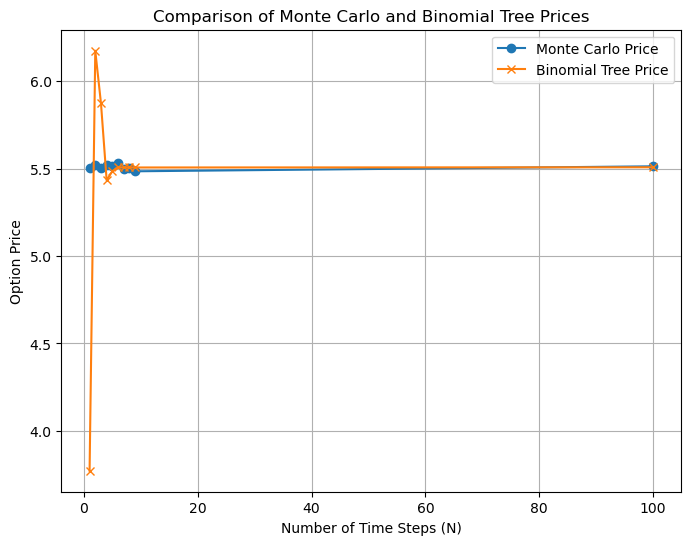

In [86]:
N_values = np.arange(1, 10, 1)
mc_prices = []
bt_prices = []

for N in N_values:
    mc_price = monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M)
    bt_price = binomial_chooser_option(S0, K, r, sigma, U, T, N)
    mc_prices.append(mc_price)
    bt_prices.append(bt_price)
    print(f"N={N}: Monte Carlo Price={mc_price:.2f}, Binomial Tree Price={bt_price:.2f}")

N_values = np.append(N_values, 100)
mc_price = monte_carlo_chooser_option(S0, K, r, sigma, U, T, 100, M)
bt_price = binomial_chooser_option(S0, K, r, sigma, U, T, 100)
mc_prices.append(mc_price)
bt_prices.append(bt_price)
print(f"N={N}: Monte Carlo Price={mc_price:.2f}, Binomial Tree Price={bt_price:.2f}")


# 绘制结果
plt.figure(figsize=(8, 6))
plt.plot(N_values, mc_prices, label='Monte Carlo Price', marker='o')
plt.plot(N_values, bt_prices, label='Binomial Tree Price', marker='x')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Option Price')
plt.title('Comparison of Monte Carlo and Binomial Tree Prices')
plt.legend()
plt.grid(True)
plt.show()

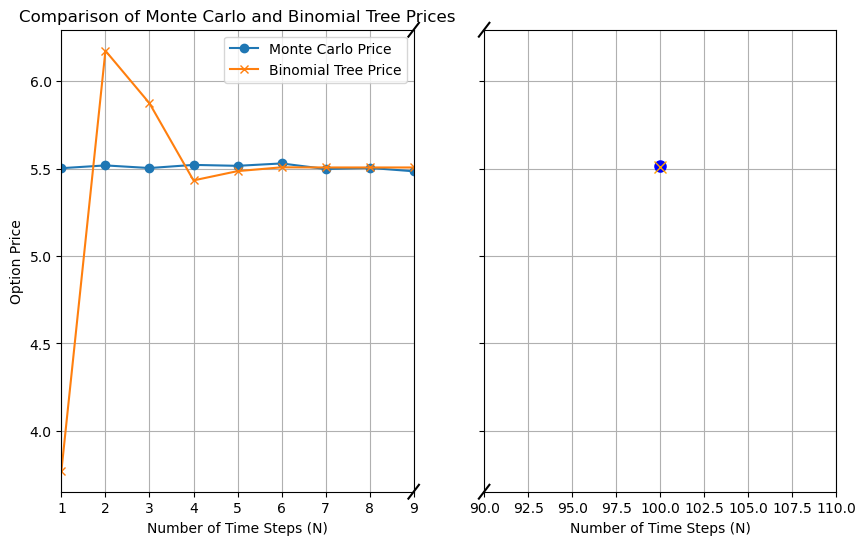

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

# 第一个子图：N=1到N=9
ax1.plot(N_values[:-1], mc_prices[:-1], label='Monte Carlo Price', marker='o')
ax1.plot(N_values[:-1], bt_prices[:-1], label='Binomial Tree Price', marker='x')
ax1.set_xlim(1, 9)
ax1.set_xlabel('Number of Time Steps (N)')
ax1.set_ylabel('Option Price')
ax1.set_title('Comparison of Monte Carlo and Binomial Tree Prices')
ax1.legend()
ax1.grid(True)

# 第二个子图：N=100
ax2.plot([100], [mc_prices[-1]], label='Monte Carlo Price (N=100)', marker='o', markersize=8, color='blue')
ax2.plot([100], [bt_prices[-1]], label='Binomial Tree Price (N=100)', marker='x', markersize=8, color='orange')
ax2.set_xlim(90, 110)
ax2.set_xlabel('Number of Time Steps (N)')
ax2.grid(True)

# 在两个子图之间添加断点标志
d = .015  # 设置断点的大小
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.show()